# Simple regression model

In [1]:
from toolbox import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

## Load data

In [4]:
ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data('./data/weather_collections/weather_daily_region.csv')

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
# setting more years improves model predictions
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 


### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

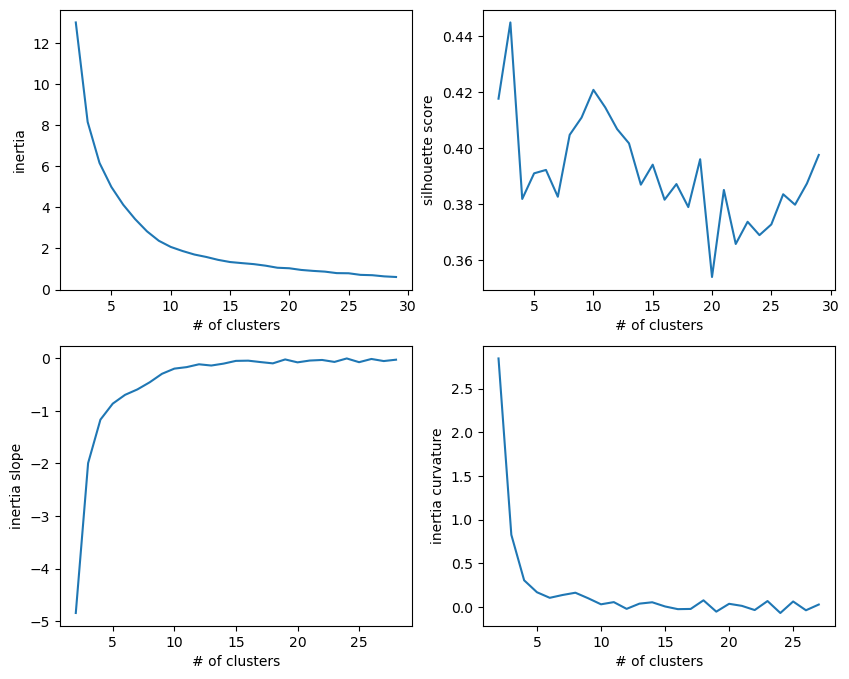

In [5]:
#explore_clusters(gs_agg[['x', 'y']])

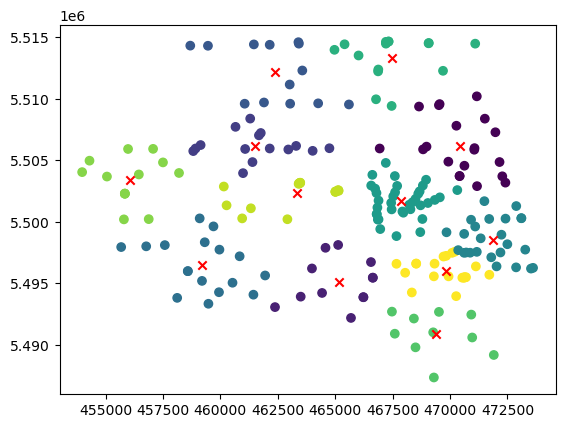

In [10]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

# Plot the points
plt.scatter(gs_agg['x'], gs_agg['y'], c=labels)#, cmap='viridis')

# Plot the cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x')

# Show the plot
plt.show()

In [11]:
gs_agg['reg_clusters'] = labels

In [5]:
g_merged = merge_groundwater_data(g, gs_agg)
g_merged.describe()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,measure_elev,lifespan,water_level_mean,water_depth_mean,water_temp_mean,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,water_depth_anomaly
count,557260.000000,557260,554273.000000,554273.000000,554273.000000,66890.00000,557260.000000,5.572600e+05,557260,557260,...,557260.000000,557260,557247.000000,557247.000000,144944.000000,556928.000000,556928.000000,556928.000000,556928.000000,553988.000000
mean,13589.102144,1995-03-01 05:35:27.078921728,3.594004,89.469690,3.220631,12.27388,465759.276823,5.501905e+06,1966-12-22 22:03:30.291784800,2017-11-11 00:57:30.511431168,...,93.146810,18586 days 02:54:00.219646208,89.466250,3.222664,12.190641,2.935128,0.382943,1.936159,3.645997,0.286287
min,12890.000000,1912-10-15 00:00:00,0.000000,81.140000,-0.870000,2.02000,453983.000000,5.487354e+06,1912-01-01 00:00:00,1966-01-01 00:00:00,...,86.500000,134 days 00:00:00,83.935770,0.968683,10.746667,0.464138,0.086603,-0.400000,1.010000,-4.982107
25%,13157.000000,1980-08-25 00:00:00,2.500000,86.900000,2.100000,11.30000,461900.003000,5.497120e+06,1953-01-01 00:00:00,2024-03-01 00:00:00,...,90.520000,15765 days 00:00:00,86.885700,2.210565,11.493786,1.906583,0.252264,0.680000,2.420000,-0.323640
50%,13568.000000,1997-12-01 00:00:00,3.360000,89.240000,3.030000,12.00000,466857.965000,5.501588e+06,1973-01-01 00:00:00,2024-03-01 00:00:00,...,93.220000,18322 days 00:00:00,89.014528,3.028495,11.959470,2.638494,0.329315,1.640000,3.410000,0.192644
75%,13774.000000,2013-08-22 00:00:00,4.400000,92.090000,4.040000,12.90000,469927.000000,5.505957e+06,1978-01-01 00:00:00,2024-03-01 00:00:00,...,95.760000,23801 days 00:00:00,91.933931,4.000772,12.636749,3.708372,0.498628,2.630000,4.630000,0.792597
max,17794.000000,2024-03-20 00:00:00,11.160000,96.270000,10.790000,21.30000,473615.000000,5.514651e+06,2013-01-01 00:00:00,2024-03-01 00:00:00,...,100.560000,40968 days 00:00:00,94.533442,8.493808,14.117103,9.237011,1.161315,7.580000,10.790000,5.809157
std,609.112889,NaN,1.527469,3.005891,1.476485,1.55057,4829.443303,6.203696e+03,NaN,NaN,...,3.032113,6842 days 14:06:22.419255168,2.932930,1.320438,0.818067,1.541130,0.175666,1.604714,1.599203,1.075466


In [6]:
g_merged.head()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,lifespan,geometry,water_level_mean,water_depth_mean,water_temp_mean,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,water_depth_anomaly
date,,,,,,,,,,,,,,,,,,,,,
1979-01-01,13595,1979-01-01,9.48,89.76,8.45,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,16861 days,POINT (8.56426 49.62114),90.031838,8.178162,NaN,8.522269,0.768206,7.05,9.65,-0.072269
1979-01-08,13595,1979-01-08,9.49,89.75,8.46,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,16861 days,POINT (8.56426 49.62114),90.031838,8.178162,NaN,8.522269,0.768206,7.05,9.65,-0.062269
1979-01-15,13595,1979-01-15,9.89,89.35,8.86,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,16861 days,POINT (8.56426 49.62114),90.031838,8.178162,NaN,8.522269,0.768206,7.05,9.65,0.337731
1979-01-29,13595,1979-01-29,9.98,89.26,8.95,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,16861 days,POINT (8.56426 49.62114),90.031838,8.178162,NaN,8.522269,0.768206,7.05,9.65,0.427731
1979-02-05,13595,1979-02-05,10.00,89.24,8.97,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,16861 days,POINT (8.56426 49.62114),90.031838,8.178162,NaN,8.522269,0.768206,7.05,9.65,0.447731


In [7]:
m = pd.merge(g_merged, w,
             how='left', left_index=True, right_index=True)

# restrict data to the post-war period
m = m.loc[m.date > pd.to_datetime('1950-01-01')]

# drop all rows with a date after the weather data cutoff date
m = m.loc[m.date <= pd.to_datetime('2022-12-31')]

m = m.dropna(subset=['station_id_count'])

m['week_of_year'] = m['date'].dt.isocalendar().week

In [8]:
#m.info()

In [9]:
m.describe()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,moisture_std,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,week_of_year
count,535080.000000,535080,532286.000000,532286.000000,532286.000000,58281.000000,535080.000000,5.350800e+05,535080,535080,...,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.0
mean,13584.383032,1995-01-26 12:10:28.768782208,3.605169,89.464313,3.229522,12.234722,465762.831671,5.501887e+06,1967-01-27 18:55:06.768333728,2017-11-06 20:27:37.017267712,...,5.245498,13.079499,56.048417,168.136895,681.624260,10.443488,10.444661,10.441032,10.405230,26.661774
min,12890.000000,1950-01-02 00:00:00,0.000000,81.140000,-0.870000,2.020000,453983.000000,5.487354e+06,1912-01-01 00:00:00,1966-01-01 00:00:00,...,0.000000,0.000000,0.325000,41.320000,422.628571,-11.031746,-8.513333,-4.064444,7.622348,1.0
25%,13159.000000,1980-11-03 00:00:00,2.500000,86.900000,2.110000,11.300000,461900.003000,5.497120e+06,1953-01-01 00:00:00,2024-03-01 00:00:00,...,3.656045,2.975000,33.757143,127.200000,596.247024,4.785714,4.592000,4.935926,9.895108,14.0
50%,13564.000000,1997-05-26 00:00:00,3.370000,89.240000,3.040000,12.000000,466857.965000,5.501538e+06,1973-01-01 00:00:00,2024-03-01 00:00:00,...,4.979960,9.500000,51.760000,163.850000,679.457143,10.403571,10.344762,10.422540,10.424680,27.0
75%,13773.000000,2012-11-19 00:00:00,4.410000,92.100000,4.070000,12.800000,469937.000000,5.505957e+06,1978-01-01 00:00:00,2024-03-01 00:00:00,...,6.601767,19.200000,73.871429,204.142857,762.800000,16.451020,16.551667,16.147460,10.970466,40.0
max,17794.000000,2022-12-31 00:00:00,11.160000,96.270000,10.790000,21.300000,473615.000000,5.514651e+06,2013-01-01 00:00:00,2024-03-01 00:00:00,...,22.487033,122.671429,214.471429,384.700000,1032.071429,28.671429,24.437778,22.301852,12.782055,53.0
std,599.613919,NaN,1.521245,2.998210,1.477947,1.549757,4850.075874,6.171791e+03,NaN,NaN,...,2.275008,12.889888,30.296119,54.912199,111.445324,7.094874,6.682626,5.995027,0.837589,15.052767


## Create intuitive dummy model

As baseline, we can assume that water_depth is proportional to temp.

In [10]:
def dummy_model(t):
    return 0.05 * t + 2

dummy_model(10)

2.5

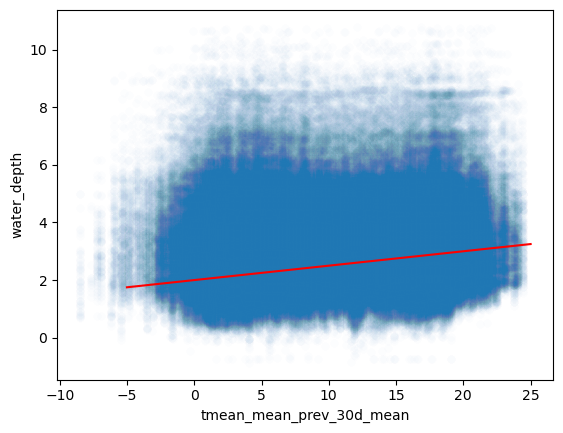

In [11]:
m_plot = m[['tmean_mean_prev_30d_mean', 'water_depth']].reset_index()
m_plot

sns.scatterplot(data=m_plot, 
            x='tmean_mean_prev_30d_mean', y='water_depth',
            alpha=0.01)
            
# works but is very slow (takes 10 minutes)
#sns.kdeplot(data=m_plot, 
#            x='tmean_mean_prev_30d_mean', y='water_depth',
               #alpha=0.01
#           )

x1, x2 = -5, 25
plt.plot([x1, x2],[dummy_model(x1), dummy_model(x2)], 'r');
            

## Train-test split

In [12]:
m.columns.unique()

Index(['station_id', 'date', 'water_dist', 'water_level', 'water_depth',
       'water_temp', 'x', 'y', 'start_date', 'end_date', 'ground_elev',
       'measure_elev', 'lifespan', 'geometry', 'water_level_mean',
       'water_depth_mean', 'water_temp_mean', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'water_depth_anomaly', 'station_id_count',
       'precip_mean', 'precip_min', 'precip_max', 'precip_std', 'tmean_mean',
       'tmean_min', 'tmean_max', 'tmean_std', 'tmax_mean', 'tmax_min',
       'tmax_max', 'tmax_std', 'tmin_mean', 'tmin_min', 'tmin_max', 'tmin_std',
       'moisture_mean', 'moisture_min', 'moisture_max', 'moisture_std',
       'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'precip_mean_prev_1y_sum',
       'tmean_mean_prev_7d_mean', 'tmean_mean_prev_30d_mean',
       'tmean_mean_prev_90d_mean', 'tmean_mean_prev_1y_mean', 'week_of_year'],
  

In [13]:
# restrict data to these columns
df = m[['station_id',
        'date',
        'water_depth',
        'ground_elev',
        'x', 'y',
        'ini_years_water_depth_mean',
        'ini_years_water_depth_std',
        'ini_years_water_depth_min',
        'ini_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean'
       ]]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 535080 entries, 1950-01-02 to 2022-12-31
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   station_id                  535080 non-null  int64         
 1   date                        535080 non-null  datetime64[ns]
 2   water_depth                 532286 non-null  float64       
 3   ground_elev                 535080 non-null  float64       
 4   x                           535080 non-null  float64       
 5   y                           535080 non-null  float64       
 6   ini_years_water_depth_mean  534748 non-null  float64       
 7   ini_years_water_depth_std   534748 non-null  float64       
 8   ini_years_water_depth_min   534748 non-null  float64       
 9   ini_years_water_depth_max   534748 non-null  float64       
 10  precip_mean                 535080 non-null  float64       
 11  tmean_mean             

In [14]:
df[df.isna().any(axis=1)]

,station_id,date,water_depth,ground_elev,x,y,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,precip_mean,tmean_mean,moisture_mean,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean
date,,,,,,,,,,,,,,,,,,,
1950-08-15,12926,1950-08-15,NaN,89.20,463419.000,5514473.000,2.641859,0.443678,1.69,3.63,0.000000,19.175000,69.428571,8.662500,100.250000,261.150000,19.533929,19.599167,19.460139
1951-07-16,13490,1951-07-16,NaN,90.13,459101.000,5500279.000,2.373881,0.165081,1.87,2.72,0.477778,14.722222,81.125000,14.888889,81.166667,210.955556,19.669841,18.000370,15.442469
1951-07-16,12895,1951-07-16,NaN,87.21,458921.000,5505957.000,0.961513,0.397709,0.12,1.78,0.477778,14.722222,81.125000,14.888889,81.166667,210.955556,19.669841,18.000370,15.442469
1951-07-16,13726,1951-07-16,NaN,93.50,466857.965,5500178.987,1.906583,0.315678,1.22,2.64,0.477778,14.722222,81.125000,14.888889,81.166667,210.955556,19.669841,18.000370,15.442469
1951-07-16,13489,1951-07-16,NaN,88.23,455802.000,5500199.000,1.208079,0.379114,-0.13,1.80,0.477778,14.722222,81.125000,14.888889,81.166667,210.955556,19.669841,18.000370,15.442469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,12901,2022-12-12,NaN,90.56,461760.000,5507216.000,3.029500,0.186197,2.56,3.46,0.000000,-2.825000,85.625000,0.075000,52.050000,223.150000,0.439286,4.616667,9.841667
2022-12-19,13764,2022-12-19,NaN,96.13,472883.576,5501280.505,4.635420,0.930456,2.53,5.61,0.025000,0.925000,85.060000,1.050000,22.325000,190.075000,-3.746429,1.835000,8.528333
2022-12-19,12901,2022-12-19,NaN,90.56,461760.000,5507216.000,3.029500,0.186197,2.56,3.46,0.025000,0.925000,85.060000,1.050000,22.325000,190.075000,-3.746429,1.835000,8.528333


In [15]:
df = df.dropna()

In [16]:
ids = list(df.station_id.unique())

# Calculate 80% of the list's length
num_elements = round(len(ids) * 0.8)

# Randomly select 80% of the elements
train_ids = random.sample(ids, k=num_elements)

In [17]:
train = df.loc[df.station_id.isin(train_ids)]
test = df.loc[~df.station_id.isin(train_ids)]

In [18]:
train

,station_id,date,water_depth,ground_elev,x,y,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,precip_mean,tmean_mean,moisture_mean,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean
date,,,,,,,,,,,,,,,,,,,
1950-01-02,13492,1950-01-02,2.40,90.30,460271.000,5501339.000,2.165060,0.232807,1.65,2.53,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,13518,1950-01-02,2.12,96.27,468337.000,5494261.000,1.996575,0.303054,1.15,2.48,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,12896,1950-01-02,1.28,88.70,462150.000,5505957.000,1.037206,0.252420,0.68,1.39,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,14082,1950-01-02,3.97,92.37,461440.000,5494081.000,3.634884,0.216650,3.09,4.00,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,14173,1950-01-02,3.43,95.72,466228.000,5493871.000,2.240109,0.547429,1.46,3.42,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,12927,2022-12-31,3.51,88.52,463399.441,5514593.283,4.062741,0.418023,3.00,4.92,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611
2022-12-31,13832,2022-12-31,2.00,93.71,470626.000,5504557.000,2.002682,0.277334,0.96,2.56,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611
2022-12-31,13836,2022-12-31,8.54,99.92,472156.000,5504857.000,8.537297,0.555361,7.58,9.40,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611


In [19]:
# define X and y
y_train = train.pop('water_depth')
y_test = test.pop('water_depth')

info_train = train[['station_id', 'date']].copy()
info_test = test[['station_id', 'date']].copy()

X_train = train.copy().drop(['station_id', 'date'], axis=1)
X_test = test.copy().drop(['station_id', 'date'], axis=1)

In [20]:
X_train

,ground_elev,x,y,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,precip_mean,tmean_mean,moisture_mean,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean
date,,,,,,,,,,,,,,,,
1950-01-02,90.30,460271.000,5501339.000,2.165060,0.232807,1.65,2.53,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,96.27,468337.000,5494261.000,1.996575,0.303054,1.15,2.48,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,88.70,462150.000,5505957.000,1.037206,0.252420,0.68,1.39,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,92.37,461440.000,5494081.000,3.634884,0.216650,3.09,4.00,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,95.72,466228.000,5493871.000,2.240109,0.547429,1.46,3.42,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,88.52,463399.441,5514593.283,4.062741,0.418023,3.00,4.92,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611
2022-12-31,93.71,470626.000,5504557.000,2.002682,0.277334,0.96,2.56,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611
2022-12-31,99.92,472156.000,5504857.000,8.537297,0.555361,7.58,9.40,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611


In [21]:
#X_train.info()
#y_test.info()

In [22]:
# test dummy model
dummy_y_test_pred = dummy_model(X_test['tmean_mean_prev_30d_mean'])
dummy_y_test_pred

date
1950-01-02    2.203875
1950-01-02    2.203875
1950-01-02    2.203875
1950-01-02    2.203875
1950-01-04    2.189750
                ...   
2022-12-30    2.139250
2022-12-31    2.158917
2022-12-31    2.158917
2022-12-31    2.158917
2022-12-31    2.158917
Name: tmean_mean_prev_30d_mean, Length: 131755, dtype: float64

In [23]:
calc_metrics(y_test, dummy_y_test_pred)

MAE 1.1544130754773922
RMSE 1.4781468984027315
MAPE 0.44359031074767574
R2 -0.15967707501659012


{'MAE': 1.1544130754773922,
 'RMSE': 1.4781468984027315,
 'MAPE': 0.44359031074767574,
 'R2': -0.15967707501659012}

In [24]:
residuals = calc_residuals(y_test, dummy_y_test_pred)

/home/philip/anaconda3/envs/geo/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


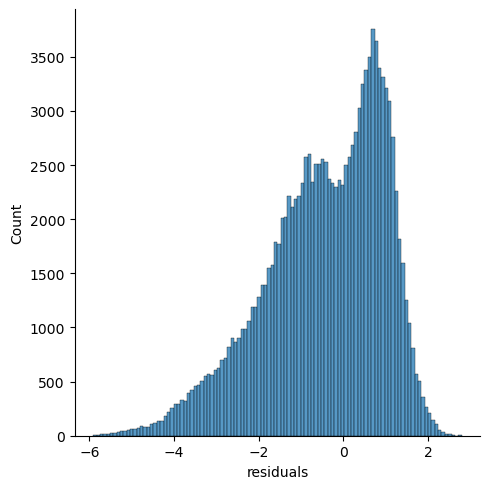

In [25]:
sns.displot(residuals['residuals'])

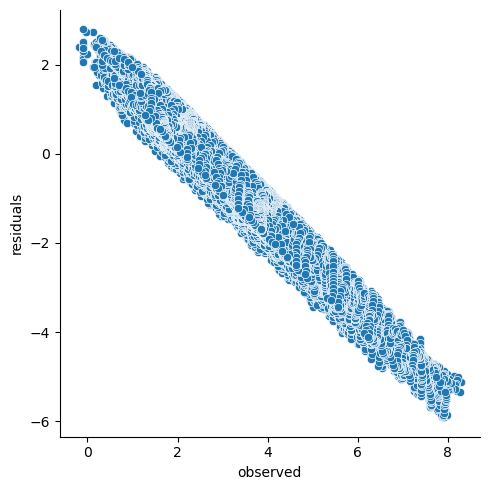

In [26]:
sns.relplot(data=residuals, x='observed', y='residuals')

## Exploratory PCA

In [27]:
pca, X_pca, pca_stats = perform_pca(X_train, 6)

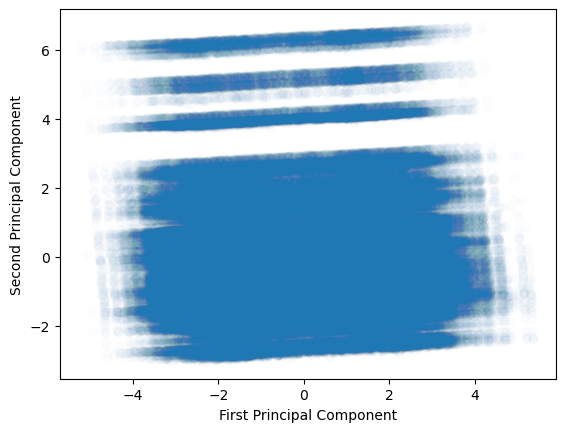

In [28]:
# Visualize the first two principal components
plt.scatter(X_pca['pca0'], X_pca['pca1'], alpha=0.01)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [29]:
pca_stats

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
Explained Variance Ratio,0.230317,0.185775,0.143324,0.128668,0.067743,0.063638
ground_elev,-0.009233,0.276537,0.037734,-0.577995,0.164523,0.009203
x,-0.000559,0.111549,0.032968,-0.586567,-0.121102,0.002476
y,0.000080,-0.094295,-0.019124,0.323213,-0.664932,-0.026191
ini_years_water_depth_mean,-0.040172,0.557913,0.001775,0.172047,-0.038712,-0.004930
ini_years_water_depth_std,-0.009816,0.058963,-0.017115,0.356116,0.656564,0.018304
ini_years_water_depth_min,-0.036609,0.541574,0.009433,0.018260,-0.277815,-0.011376
ini_years_water_depth_max,-0.039396,0.537811,-0.001660,0.239666,0.072191,-0.002545
precip_mean,0.005052,-0.007224,0.389020,0.025899,-0.023024,0.630387
tmean_mean,-0.487983,-0.033650,-0.013760,-0.009079,-0.000077,0.016976


In [30]:
pca.components_

array([[-9.23272314e-03, -5.59380962e-04,  7.98814823e-05,
        -4.01716560e-02, -9.81609098e-03, -3.66089403e-02,
        -3.93961387e-02,  5.05236543e-03, -4.87982549e-01,
         2.68121671e-01, -5.84920770e-03, -2.67680415e-02,
        -3.45649987e-02, -5.02179197e-01, -5.03653160e-01,
        -4.21277097e-01],
       [ 2.76536624e-01,  1.11549230e-01, -9.42946539e-02,
         5.57913234e-01,  5.89625144e-02,  5.41574071e-01,
         5.37810964e-01, -7.22370627e-03, -3.36504684e-02,
         1.51544806e-02, -9.75074165e-03, -1.33871260e-02,
        -1.47389409e-02, -3.40498100e-02, -3.37894272e-02,
        -2.64401867e-02],
       [ 3.77337679e-02,  3.29677034e-02, -1.91238479e-02,
         1.77522162e-03, -1.71154313e-02,  9.43281157e-03,
        -1.66028322e-03,  3.89020099e-01, -1.37604731e-02,
         3.04789535e-01,  5.13456285e-01,  5.30756491e-01,
         4.46212398e-01,  1.03908095e-02,  3.59877671e-02,
         8.04033447e-02],
       [-5.77994907e-01, -5.86566706e

## Build pipeline

### Define preprocessing steps

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400246 entries, 1950-01-02 to 2022-12-31
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ground_elev                 400246 non-null  float64
 1   x                           400246 non-null  float64
 2   y                           400246 non-null  float64
 3   ini_years_water_depth_mean  400246 non-null  float64
 4   ini_years_water_depth_std   400246 non-null  float64
 5   ini_years_water_depth_min   400246 non-null  float64
 6   ini_years_water_depth_max   400246 non-null  float64
 7   precip_mean                 400246 non-null  float64
 8   tmean_mean                  400246 non-null  float64
 9   moisture_mean               400246 non-null  float64
 10  precip_mean_prev_7d_sum     400246 non-null  float64
 11  precip_mean_prev_30d_sum    400246 non-null  float64
 12  precip_mean_prev_90d_sum    400246 non-null  float64
 13

In [32]:
# select categorical and numerical column names
#X_cat_columns = X_train.select_dtypes(exclude="number").columns
X_num_columns = X_train.select_dtypes(include="number").columns

# create numerical pipeline
num_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='mean')), # probably not needed...
           #('num_scaler', MinMaxScaler())
           ('num_scaler', StandardScaler())
          ])

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
#categoric_pipe = Pipeline(
#    steps=[('cat_imputer', SimpleImputer(strategy='constant', 
#                                         fill_value='na')), 
#           ('cat_encoder', OneHotEncoder(drop='first', 
#                                         sparse_output=False, 
#                                         handle_unknown='ignore'))
           #('cat_encoder', OrdinalEncoder())
#          ])

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, X_num_columns), 
        #('cat', categoric_pipe, X_cat_columns)
    ],
    #remainder='passthrough'
).set_output(transform='pandas')

In [34]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  StandardScaler())]),
                                 Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean'],
      dtype='object'))])

### Define regressors to test

In [35]:
regressors = [
    #('DecisionTree', DecisionTreeRegressor()),
    #('SGD', SGDRegressor()),
    ('LinReg', LinearRegression()),
    ('PLS', PLSRegression()),
    #('RandForest', RandomForestRegressor()) # best so far but costly (>10 min)
]

### Create a pipeline for each classifier

In [36]:
pipelines = {}
for name, reg in regressors:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('selector', SelectKBest(score_func=f_regression)),
        #('selector', RFECV(estimator=DecisionTreeRegressor())),
        #('feature_selection', SelectFromModel(DecisionTreeRegressor())),
        ('regressor', reg)
     ]).set_output(transform="pandas")
    pipelines[name] = pipeline


In [37]:
pipelines['PLS']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean'],
      dtype='object'))])),
                ('regressor', PLSRegression())])

## Inspect models

stats from dummy model: 

MAE 1.180524150300254

RMSE 1.5993132760325228

MAPE 495545893932.64526

R2 -0.3085209566128313

In [38]:
predictions = {}
metrics = {}
residuals = {}

for name in pipelines:
    print(name)
    pipe = pipelines[name]

    #print('FITTING')
    pipe.fit(X_train, y_train)

    #print('PREDICTING')
    y_pred = pipe.predict(X_test)

    # save
    predictions[name] = y_pred
    metrics[name] = calc_metrics(y_test, y_pred)
    residuals[name] = calc_residuals(y_test, y_pred)

LinReg
MAE 0.7043399102333981
RMSE 0.9554433902970569
MAPE 0.2764503869077689
R2 0.5154798982455286
PLS
MAE 0.7493889033968508
RMSE 1.020326791716594
MAPE 0.30190382918855263
R2 0.44743870598775026


In [39]:
#residuals['DecisionTree']

In [40]:
compare_models = pd.DataFrame(metrics)
compare_models

,LinReg,PLS
MAE,0.704340,0.749389
RMSE,0.955443,1.020327
MAPE,0.276450,0.301904
R2,0.515480,0.447439


LinReg


/home/philip/anaconda3/envs/geo/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


PLS


/home/philip/anaconda3/envs/geo/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


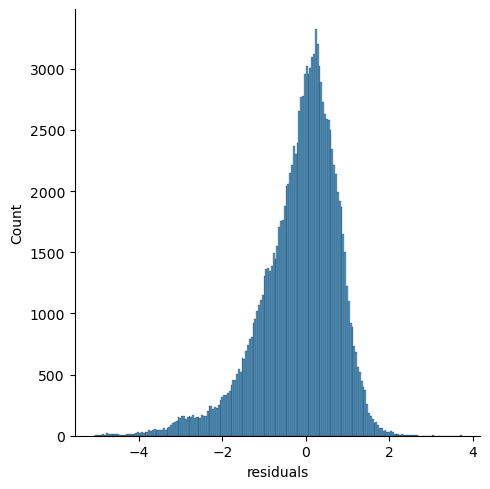

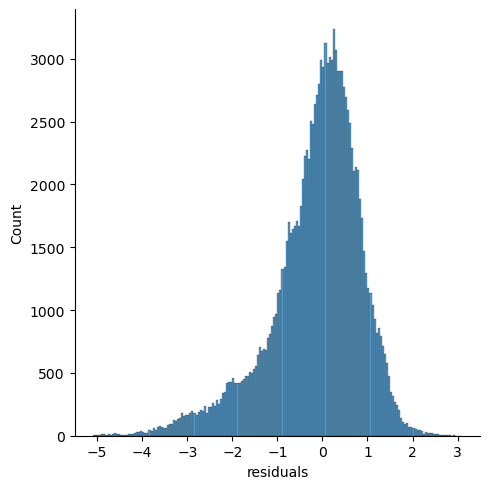

In [41]:
for name in residuals:
    print(name)
    r = residuals[name]
    sns.displot(r['residuals'])

LinReg (131755, 3)
PLS (131755, 3)


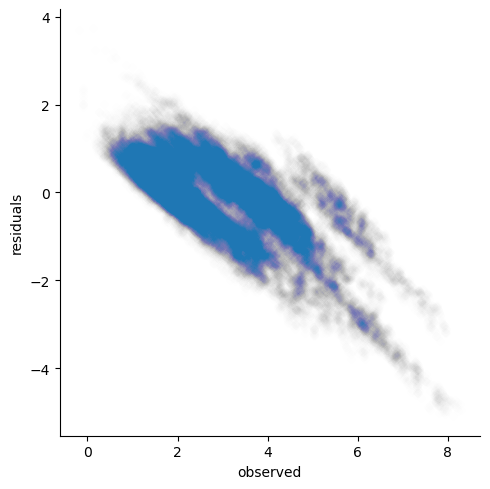

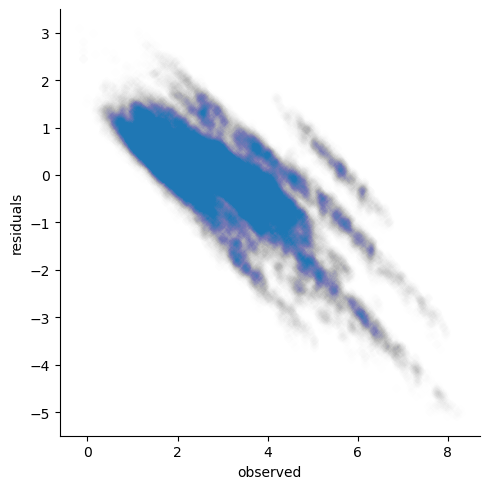

In [42]:
for name in residuals:
    r = residuals[name]
    print(name, r.shape)
    sns.relplot(data=r, x='observed', y='residuals', alpha=0.005)

In [43]:
y_pred = predictions['PLS']

y_pred = pd.DataFrame(y_pred, columns=['pred_water_depth'])
y_pred.index = info_test.index
#y_pred

In [44]:
test = pd.concat([info_test, X_test, y_test, y_pred],
                 axis='columns')

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131755 entries, 1950-01-02 to 2022-12-31
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   station_id                  131755 non-null  int64         
 1   date                        131755 non-null  datetime64[ns]
 2   ground_elev                 131755 non-null  float64       
 3   x                           131755 non-null  float64       
 4   y                           131755 non-null  float64       
 5   ini_years_water_depth_mean  131755 non-null  float64       
 6   ini_years_water_depth_std   131755 non-null  float64       
 7   ini_years_water_depth_min   131755 non-null  float64       
 8   ini_years_water_depth_max   131755 non-null  float64       
 9   precip_mean                 131755 non-null  float64       
 10  tmean_mean                  131755 non-null  float64       
 11  moisture_mean          

In [46]:
test.describe()

,station_id,date,ground_elev,x,y,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,precip_mean,tmean_mean,moisture_mean,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,water_depth,pred_water_depth
count,131755.000000,131755,131755.000000,131755.000000,1.317550e+05,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000,131755.000000
mean,13478.650313,1992-09-17 00:00:49.182194176,93.068353,466738.734556,5.500824e+06,2.398733,0.344961,1.549704,3.090765,1.904157,10.415773,75.613940,13.081583,56.069980,168.256679,10.399683,10.398924,10.391505,2.970738,2.826680
min,12891.000000,1950-01-02 00:00:00,87.630000,455982.000000,5.487354e+06,0.464138,0.103258,-0.100000,1.010000,0.000000,-14.933333,32.250000,0.000000,0.325000,41.320000,-10.571429,-8.513333,-4.064444,-0.190000,0.992035
25%,13149.000000,1975-10-20 00:00:00,90.540000,463039.549000,5.496201e+06,1.179579,0.244330,0.590000,2.110000,0.000000,4.673214,66.750000,2.975000,33.600000,126.950000,4.735714,4.554286,4.888222,1.870000,2.081683
50%,13544.000000,1994-09-05 00:00:00,94.300000,468427.000000,5.500279e+06,2.348725,0.286985,0.950000,3.030000,0.114286,10.557143,77.714286,9.520000,51.860000,163.800000,10.377551,10.321667,10.366944,2.770000,2.719180
75%,13727.000000,2012-07-01 00:00:00,95.690000,470586.000000,5.505877e+06,3.241313,0.400243,2.270000,3.670000,2.083333,16.414286,85.666667,19.225000,74.075000,204.442857,16.382857,16.521500,16.102222,3.820000,3.346532
max,14166.000000,2022-12-31 00:00:00,98.780000,473525.000000,5.514473e+06,6.275292,0.779637,5.900000,6.710000,51.200000,30.000000,99.500000,90.025000,210.500000,384.700000,28.300000,24.400000,22.268519,8.290000,6.112930
std,378.077047,NaN,2.954452,4401.736601,6.447968e+03,1.249645,0.149893,1.292689,1.226330,3.859354,7.462503,12.584175,12.883540,30.336244,55.296058,7.090497,6.681830,5.997318,1.372621,0.909206


In [47]:
test.head()

,station_id,date,ground_elev,x,y,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,precip_mean,tmean_mean,moisture_mean,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,water_depth,pred_water_depth
date,,,,,,,,,,,,,,,,,,,,
1950-01-02,13491,1950-01-02,89.77,461330.000,5501099.000,1.375745,0.218806,0.85,2.03,7.3250,0.2000,79.857143,7.525,57.8250,144.85,2.825000,4.0775,6.524861,1.59,2.269865
1950-01-02,14166,1950-01-02,95.85,468427.000,5492142.000,0.464138,0.276676,-0.10,1.01,7.3250,0.2000,79.857143,7.525,57.8250,144.85,2.825000,4.0775,6.524861,1.74,1.659797
1950-01-02,12942,1950-01-02,90.90,464019.133,5505766.787,2.107667,0.153382,1.75,2.51,7.3250,0.2000,79.857143,7.525,57.8250,144.85,2.825000,4.0775,6.524861,2.19,2.771609
1950-01-02,12902,1950-01-02,87.63,460660.483,5507716.036,2.117403,0.498628,1.03,2.91,7.3250,0.2000,79.857143,7.525,57.8250,144.85,2.825000,4.0775,6.524861,3.03,2.650243
1950-01-04,13582,1950-01-04,92.91,463989.000,5496211.000,2.700833,0.291171,2.26,3.26,5.3625,3.3375,87.142857,13.800,58.5875,151.30,1.503571,3.7950,6.294028,2.94,3.251784


In [48]:
test.station_id.unique()[0]

13491

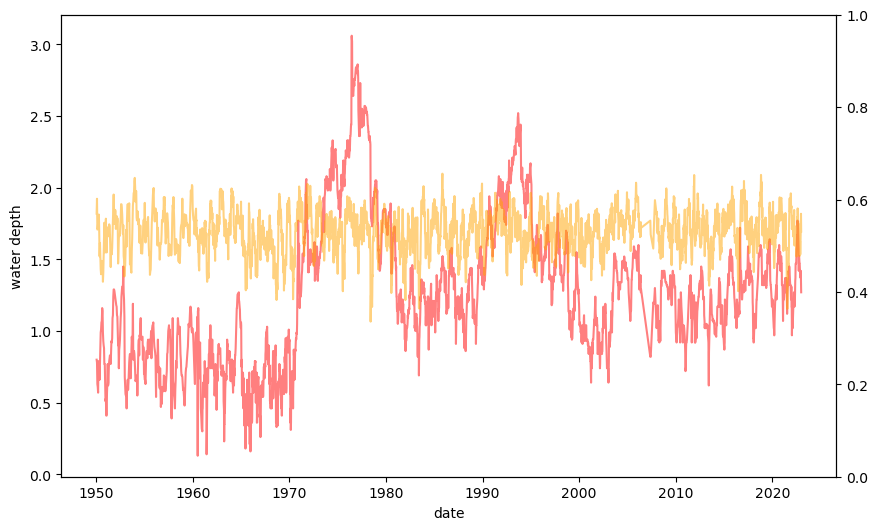

In [49]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

#data = test.loc[test.station_id == 13500]
data = test.loc[test.station_id == test.station_id.unique()[10]]

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='r', alpha=0.5,
             data=data,
             ax=ax)

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="pred_water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='orange', alpha=0.5,
             data=data,
             ax=ax)

# Create a secondary y-axis
ax2 = ax.twinx()

# Plot the second DataFrame on the secondary y-axis
#sns.lineplot(x="date", y="tmean_mean_prev_7d_mean", 
#             data=data,#['1983-01':'1985-01'], # filter dates here
#             ax=ax2, 
#             color='b'
#            )

# Optionally, set labels for the y-axes
ax.set_ylabel('water depth')
#ax2.set_ylabel('Y2 Label')

# Set the x-axis limits
#start_date = pd.to_datetime('1970-01-01')
#end_date = pd.to_datetime('1985-01-10')
#plt.xlim(start_date, end_date)

# Show the plot
plt.show()

## TODO

- check all test stations if there are some where predictions performed well
- implement location encoding by
    - discretizing x and y (pd.cut) and bucketing --> x-y grid
    - performing clustering on the points with dbscan, kmean, knn, ...
- try to predict water_depth_anomaly
- try with lag-shifted data...
- hyperparameter search
- more models